In [66]:
## Basic Packages

import time
from math import sqrt, pi
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re

## Sklearn packages

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

## Spotipy packages (Spotify API)

import spotipy.oauth2
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util
import spotipy

## Importing Bokeh to explore outliers

from bokeh.plotting import figure, output_file, show
import bokeh.models as bmo
from bokeh.palettes import d3
from bokeh.models import Legend, BoxSelectTool, BoxZoomTool, LassoSelectTool
import bokeh.plotting as bpl

## Notebook display settings

pd.options.display.max_columns = 999

start_time = time.time()

## Audio feature descriptions

#https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

In [4]:
token = util.prompt_for_user_token(username = sp_username, client_id= sp_client_id,client_secret= sp_client_secret,redirect_uri=sp_redirect_uri)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=c11d185f127941938988ee6a37061b85&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A8777%2Fcallback%2F in your browser


Enter the URL you were redirected to: http://localhost:8777/callback/?code=AQDWwU5A3qqtBUvSZkJNSXHl1p1WCXgh6KLmFvpWf-sb7_J4bG6gI3hhus4u5GTYNCmUlDCJSloLbIpMPJ2wK7dh__hPLxN-Dg7meyGF9H2ZXusVLyIkHrlVVPmKWSq1ulKhQ12ohD3bsVWTHmKzZzqPOfA_q9u_4ClryFc-xTLIgzNDUABXWvQ9ESQIup_R6ybbeWQ




In [5]:
sp = spotipy.Spotify(auth=token)

## Functions Related to API Calls

In [6]:
def sp_search_artist(sp_artist_name):
        ## Takes user name from user input and searches for artist information - returns dataframe
        artist_search_results = sp.search(q = sp_artist_name, limit = 1, type = 'artist')
        artist_search_results_2 = artist_search_results['artists']
        artist_search_results_3 = artist_search_results_2['items']
        sp_search_artists_df = pd.DataFrame(artist_search_results_3)
        return sp_search_artists_df

In [7]:
def sp_search_track(sp_track_id):
        ## Takes user name from user input and searches for artist information - returns dataframe
        track_search_results = sp.search(q = sp_track_id, limit = 10, type = 'track')
        track_search_results_2 = track_search_results['track']
        track_search_results_3 = track_search_results_2['items']
        sp_search_track_df = pd.DataFrame(track_search_results_3)
        return sp_search_track_df

In [8]:
def sp_search_album(sp_artist_id):
        ## Search for albums based on artist ID
        album_search_results = sp.artist_albums(sp_artist_id, album_type = 'album')
        album_search_results_2 = album_search_results['items']
        sp_search_album_df = pd.DataFrame(album_search_results_2)       
        return sp_search_album_df

In [9]:
def sp_search_track(album, alb_num, rel_date):
        ## Function that utilizes Spotify's album_tracks method to return all tracks from an album ID
        track_search_results = sp.album_tracks(album, limit = 50)
        track_search_results_2 = track_search_results['items']
        sp_search_track_df = pd.DataFrame(track_search_results_2)
        sp_search_track_df['album_name'] = alb_num
        sp_search_track_df['release_date'] = rel_date
        return sp_search_track_df

In [10]:
def sp_features_audio(song_list):
        ## Function that utilizes Spotify's audio_features method to return audio features (energy, tempo, etc)
        audio_features_results = sp.audio_features(tracks = song_list)
        audio_df = pd.DataFrame(audio_features_results)
        return audio_df

In [11]:
def audio_track_analysis(song_list):
        ## Function that utilizes Spotify's audio_features method to return audio features (energy, tempo, speechiness, etc)
        audio_analysis_list = []
        for i in range(len(song_list)):
            results = sp.audio_analysis(song_list[i])
            audio_analysis_list.append(results)
        track_df = pd.DataFrame(audio_analysis_list)
        return track_df

In [12]:
def sp_track_info(song_list):
        track_info_results = sp.tracks(song_list)
        track_info_df = pd.DataFrame(track_info_results['tracks'])
        return track_info_df

## General functions (not related to Spotify API)

In [13]:
def count_stats (column, df):
    count_list = []
    for row in range(len(df)):
        count = 0
        for item in range(len(df.iloc[row, column])):
            count += 1
        count_list.append(count)
    return count_list

In [14]:
## Function that takes a dataframe and iterates through columns to calculate predicted value

def future_value(df, req_feat):
    ## Will iterate through columns to calculate future value
    requested_df = df[df.feature == req_feat]

    x_reg = np.array(requested_df.album_number)
    y_reg = np.array(requested_df.value)

    fit = np.polyfit(x_reg, y_reg, 1)
    fit_fn = np.poly1d(fit) 

    ## Fit the linear regression model to the expected 14th value
    return fit_fn(14)

In [15]:
## Function to normalize features

def feature_norm(df, col):
    return(df[col] - df[col].min())/(df[col].max() - df[col].min())

## Creating Dataframes from API Calls

In [16]:
## Search for artist by input

artist_search_df = sp_search_artist(input("What artists would you like to see? "))

## Collect artist id and genres

artist_search_id = list(artist_search_df.id)

artist_search_genre = list(artist_search_df.genres)
artist_search_genre = artist_search_genre[0]

What artists would you like to see? Arctic Monkeys


In [17]:
## Starting to build album information, then saving off information for later calls

album_search_df = sp_search_album(artist_search_id[0])

album_name_list = list(album_search_df.name)
album_id = list(album_search_df.id)
album_release_date = list(album_search_df.release_date)

In [18]:
## Iterating through albums to return a dataframe with track information

for i in range(len(album_id)):
    if i == 0:
        album_track_df = sp_search_track(album_id[i], album_name_list[i], album_release_date[i])
    else:
        new_track_df = sp_search_track(album_id[i], album_name_list[i], album_release_date[i])
        album_track_df = album_track_df.append(new_track_df)
        album_track_df.reset_index(drop = True, inplace = True)

In [19]:
## Track list will be used to get audio_features and track_analysis for each song        
        
track_list = list(album_track_df.id)

## Audio features for each song

for i in range(len(track_list)):
    if i == 0:
        audio_features_df = sp_features_audio(track_list[i])
    else:
        new_audio_features_df = sp_features_audio(track_list[i])
        audio_features_df = audio_features_df.append(new_audio_features_df)
        audio_features_df.reset_index(drop = True, inplace = True)  

In [20]:
## Track analysis for each song

track_analysis_df = audio_track_analysis(track_list)
track_analysis_df.drop(columns = ['meta', 'track'], inplace = True)

## Creating counts for each track_analysis record

bars_count = count_stats(0, track_analysis_df)
beats_count = count_stats(1, track_analysis_df)
sections_count = count_stats(2, track_analysis_df)
segments_count = count_stats(3, track_analysis_df)
tatums_count = count_stats(4, track_analysis_df)

audio_df = pd.DataFrame({'bars_count': bars_count, 'beats_count': beats_count, 
                      'sections_count': sections_count, 'segments_count': segments_count, 
                      'tatums_count': tatums_count})

In [21]:
## Appending track id numbers to audio analysis

track_series = pd.Series(track_list)

audio_df = pd.concat([audio_df,track_series], axis = 1)
audio_df = audio_df.rename(columns = {0 : 'id'})

## Combining audio features and audio analysis features

combined_df = pd.merge(album_track_df, audio_features_df, how = 'left', on = 'id')

## Renaming columns in merged_df

combined_df = combined_df[['href', 'id', 'name', 'track_number', 'album_name', 'release_date',
    'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 
    'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]

audio_df = pd.concat([combined_df, audio_df], axis=1)

## Creating a new field for song length (in seconds)

song_length = []

for i in range(len(album_track_df)):
    song_seconds = (album_track_df['duration_ms'][i] / 1000)
    song_length.append(song_seconds)

## Calculating beats per minute and 

song_len = pd.Series(song_length)

audio_analysis = pd.concat([audio_df, song_len], axis = 1)

audio_analysis.rename(columns = {0 : 'song_length_seconds'}, inplace = True)

audio_analysis['bpm'] = (audio_analysis['beats_count'] / (audio_analysis['song_length_seconds'] / 60))

audio_analysis = audio_analysis.rename(columns = {'name' : 'song_name'})

cols_to_use = combined_df.columns.difference(audio_analysis.columns)

merged_df = pd.merge(audio_analysis, combined_df[cols_to_use], how = 'left', left_index=True, right_index=True)

## Trimming down the audio features that I want to explore initially

features_df = combined_df[['release_date', 'album_name', 'name', 'acousticness', 'danceability', 'energy', 
    'loudness', 'key', 'mode', 'tempo', 'valence']]

## Separating the release date into year, month, day columns

features_df['year'], features_df['month'], features_df['day'] = features_df['release_date'].str.split('-',2).str

## Sort oldest album to newest album

features_df = features_df.sort_values(by = ['year', 'month', 'day'])

## Reset index and assign unique release dates to a list that will be used in the next loop

features_df.reset_index(drop = True, inplace = True)

unique_release = list(features_df.release_date.unique())

## For loop that assigns an album number based on the release date for future plotting

album_number = []

count = 0
record_number = 1

for row in range(len(features_df)):
    if features_df.release_date.iloc[row] == unique_release[count]:
        #print(features_df.release_date.iloc[row], "-------->", unique_release[count], "------->", features_df.release_date.iloc[row] == unique_release[count])
        album_number.append(record_number)
    else:
        #print('Change Album')
        record_number += 1
        count += 1
        album_number.append(record_number)

## Converting resulting list into a dataframe to concat, then renaming the column to show album_number

album_number = pd.DataFrame(album_number)

features_df = pd.concat([features_df, album_number], axis = 1)

features_df.rename(columns = {0 : 'album_number', 'name' : 'song_name'}, inplace = True)

C:\Users\Justin\AppData\Local\Programs\Python\Python36-32\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Creating Raw Dataframe for Linear Regression - Song Recommender

In [22]:
cols_to_use_2 = merged_df.columns.difference(features_df.columns)

raw_features_df = pd.merge(merged_df[cols_to_use_2], features_df, how = 'left', left_on='name', right_on='song_name')

In [23]:
raw_features_df_2 = raw_features_df

In [24]:
# raw_features_df.to_csv('arctic monkeys.csv')

## Creating a melted dataframe for predicting future song features

In [25]:
## Rearranging columns

melted_df = raw_features_df[['release_date',
                            'album_number',
                            'album_name',
                            'track_number',
                            'song_name',
                            'year',
                            'month',
                            'day',
                            'acousticness',
                            'danceability',
                            'energy',
                            'loudness',
                            'valence',
                            'song_length_seconds']]

In [26]:
## Reshaping dataframe to a long format

melted_df = pd.melt(melted_df, 
                   id_vars = ['release_date',
                            'album_number',
                            'album_name',
                            'track_number',
                            'song_name',
                            'year',
                            'month',
                            'day'], 
                   var_name = 'feature', value_name = 'value')

## Performing PCA on requested artist

In [27]:
## Normalizing data for plotting

feature_col_names = ['acousticness',
                     'danceability',
                     'energy',
                     'loudness',
                     'bars_count',
                     'beats_count',
                     'sections_count',
                     'segments_count',
                     'tatums_count',
                     'song_length_seconds',
                     'bpm']

## Iterating through columns to normalize the data 

for i in feature_col_names:
    raw_features_df[i] = feature_norm(raw_features_df, i)

## Reducing features

pca_df = raw_features_df[['album_number',
                     'acousticness',
                     'danceability',
                     'energy',
                     'bars_count',
                     'sections_count',
                     'segments_count',
                     'tatums_count',
                     'song_length_seconds',
                     'bpm']]

## Splitting data into target and features

y = pca_df['album_number']
X_norm = pca_df.iloc[:,1:]

## Requesting to use n_compenents that accounts for 95% of variance and applying fit_transform to the model

pca = sklearnPCA(n_components = .95)
transformed = pd.DataFrame(pca.fit_transform(X_norm))

## Print statements to show the impact of each feature

pca_len = len(pca.explained_variance_)

## Linear Discriminant Analysis - Requested Artist

In [28]:
## Defining 4 components for LDA and applying fit_transform

lda = LinearDiscriminantAnalysis(n_components = pca_len)
transformed_lda = pd.DataFrame(lda.fit_transform(X_norm, y))

## Defining 4 components for LDA and applying fit_transform

tsne = TSNE(n_components = 2, perplexity = 80, learning_rate = 850)
transformed_tsne = pd.DataFrame(tsne.fit_transform(transformed_lda))

## Creating new df for interactive Bokeh graphs

tsne_df = pd.concat([raw_features_df[['album_name', 'song_name', 'album_number']], transformed_tsne.iloc[:,:2]], axis=1, join_axes=[raw_features_df.index])

tsne_df.rename(columns = {0 : 'x', 1 : 'y'}, inplace = True)

## TSNE Plot - Requested Artist

In [29]:
## Resetting the html output to prevent multiple graphs from showing up

bpl.reset_output()

## Hover tool set to show album number, album name and song name

hover = bmo.HoverTool(
    tooltips = [
        ('Album #: ', '@album_number'),
        ('Album Name: ', '@album_name'),
        ('Song Name: ', '@song_name')])

## Configuring tools that will be used in the plot (plot size is large for viewing on monitor and not laptop)

p = figure(tools = [hover, "box_select, box_zoom, lasso_select, reset"], plot_width = 1200, plot_height = 800,  toolbar_location = 'above')

## Removing all lines and text, since location on the grid doesn't add any information for analysis

p.xaxis.major_tick_line_color = None
p.xaxis.minor_tick_line_color = None
p.xaxis.axis_line_color = None
p.xaxis.major_label_text_font_size = '0pt'

p.yaxis.major_tick_line_color = None
p.yaxis.minor_tick_line_color = None
p.yaxis.axis_line_color = None
p.yaxis.major_label_text_font_size = '0pt'

p.grid.visible = False

## Creating color palette/map

palette = d3['Category20'][len(tsne_df['album_name'].unique())]
color_map = bmo.CategoricalColorMapper(factors = tsne_df['album_name'].unique(), palette = palette) 

p.background_fill_color = '#2c3134'
p.background_fill_alpha = 0.5

## Creating plots and legend information

plot_names = []
legend_list = []

for i in range(len(album_name_list)):
    plot_names.append("tsne_plot_" + str(i))
     
for j in range(len(plot_names)):
    plot_names[j] = p.circle(x = 'x', y = 'y', source = tsne_df[tsne_df.album_name == album_name_list[j]], color = palette[j], 
                        size = 6, alpha = 0.75, muted_color = palette[j], muted_alpha = 0.1)
    legend_list.append((album_name_list[j], [plot_names[j]]))
    
legend = Legend(items = legend_list, location = (0,30))

p.add_layout(legend, 'right')
p.legend.click_policy = 'mute'

## Show the Results

output_file("TSNE_plot.html")
bpl.output_notebook()
show(p)

Loading BokehJS ...

## Predicting future album features

In [30]:
## Creating a key:value dictionary pair from the unique features
## This will be used by spotify to recommend similar songs to our predicted values

keys = []
values = []

unique_feat_list = list(melted_df.feature.unique())

for i in unique_feat_list:
    keys.append(i)
    values.append(future_value(melted_df, i))

pred_dicts = dict(zip(keys, values))

## Spotify asks for the recommended song length in ms

pred_dicts['song_length_seconds'] = round(pred_dicts['song_length_seconds']*1000)

## Uses the artist seed and predicted values to return songs that are similiar

results = sp.recommendations(seed_artists = artist_search_id, limit = 10,
                                     target_acousticness = pred_dicts['acousticness'],
                                     target_danceability = pred_dicts['danceability'],
                                     target_energy = pred_dicts['energy'],
                                     target_loudness = pred_dicts['loudness'],
                                     target_target_duration_ms = pred_dicts['song_length_seconds'],
                                     target_valence = pred_dicts['valence'])

## Unpack values and create a dataframe

results = results['tracks']

recommend_df = pd.DataFrame(results)

## Taking the track ID for additional analysis, plus the song popularity to incorporate popular areas to move into

recommended_tracks = []
popularity = []

for i in range(len(recommend_df)):
    recommended_tracks.append(recommend_df.uri[i])
    popularity.append(recommend_df.popularity[i])

## Call function and store audio features from recommended songs into a dataframe

recommend_audio_feat = sp_features_audio(recommended_tracks)

## Call function and store audio track features from recommended songs into a dataframe

recommend_track_analysis = audio_track_analysis(recommended_tracks)

## Creating counts for each track_analysis record

bars_count_rec = count_stats(0, recommend_track_analysis)
beats_count_rec = count_stats(1, recommend_track_analysis)
sections_count_rec = count_stats(2, recommend_track_analysis)
segments_count_rec = count_stats(3, recommend_track_analysis)
tatums_count_rec = count_stats(4, recommend_track_analysis)

audio_df_recommend = pd.DataFrame({'bars_count': bars_count, 'beats_count': beats_count, 
                      'sections_count': sections_count, 'segments_count': segments_count, 
                      'tatums_count': tatums_count})

## Creating a new field for song length (in seconds)

song_length_rec = []

for i in range(len(recommend_audio_feat)):
    song_seconds_rec = (recommend_audio_feat['duration_ms'][i] / 1000)
    song_length_rec.append(song_seconds_rec)

## Calculating beats per minute and 

song_len_rec = pd.Series(song_length_rec)

song_len_rec = song_len_rec.rename('song_length_seconds')

audio_analysis_rec = pd.concat([audio_df_recommend, song_len_rec], axis = 1)

audio_analysis_rec['bpm'] = (audio_analysis_rec['beats_count'] / (audio_analysis_rec['song_length_seconds'] / 60))

## Merge track analysis and audio features, then append an album 

raw_df_recommend = pd.merge(recommend_audio_feat, audio_analysis_rec, how = 'left', left_index = True, right_index = True)
raw_df_recommend['album_number'] = len(raw_features_df.album_number.unique()) + 1

raw_df_recommend['spotify_link'] = 'https://embed.spotify.com/?uri=spotify:track:' + raw_df_recommend.id

## Popular Albums in the Same Space

In [31]:
## Uses the artist seed and predicted values to return songs that are similiar

results = sp.recommendations(seed_artists = artist_search_id, limit = 10, min_popularity = 75,
                                     target_acousticness = pred_dicts['acousticness'],
                                     target_danceability = pred_dicts['danceability'],
                                     target_energy = pred_dicts['energy'],
                                     target_loudness = pred_dicts['loudness'],
                                     target_target_duration_ms = pred_dicts['song_length_seconds'],
                                     target_valence = pred_dicts['valence'])

## Unpack values and create a dataframe

results = results['tracks']

recommend_df = pd.DataFrame(results)

## Taking the track ID for additional analysis, plus the song popularity to incorporate popular areas to move into

recommended_tracks = []
popularity = []

for i in range(len(recommend_df)):
    recommended_tracks.append(recommend_df.uri[i])
    popularity.append(recommend_df.popularity[i])
  

  
## Creating a popularity Series for plotting

popularity_series = pd.Series(popularity)
popularity_series = popularity_series.rename("popularity")

## Pulling data for recommendations for plotting

In [32]:
## Audio features for each song

for i in range(len(recommended_tracks)):
    if i == 0:
        rec_audio_features_df = sp_features_audio(recommended_tracks[i])
    else:
        rec_new_audio_features_df = sp_features_audio(recommended_tracks[i])
        rec_audio_features_df = rec_audio_features_df.append(rec_new_audio_features_df)
        rec_audio_features_df.reset_index(drop = True, inplace = True)  

In [33]:
## Track analysis for each song

rec_track_analysis_df = audio_track_analysis(recommended_tracks)
rec_track_analysis_df.drop(columns = ['meta', 'track'], inplace = True)

## Creating counts for each track_analysis record

bars_count = count_stats(0, rec_track_analysis_df)
beats_count = count_stats(1, rec_track_analysis_df)
sections_count = count_stats(2, rec_track_analysis_df)
segments_count = count_stats(3, rec_track_analysis_df)
tatums_count = count_stats(4, rec_track_analysis_df)

rec_audio_df = pd.DataFrame({'bars_count': bars_count, 'beats_count': beats_count, 
                      'sections_count': sections_count, 'segments_count': segments_count, 
                      'tatums_count': tatums_count})

In [34]:
## Combining audio features and audio analysis features

rec_combined_df = pd.merge(rec_audio_df, rec_audio_features_df, how = 'left', left_index = True, right_index = True)

In [35]:
## Calulating song length seconds

rec_combined_df['song_length_seconds'] = (rec_combined_df['duration_ms'] / 1000) 

## Calculating beats per minute

rec_combined_df['bpm'] = (rec_combined_df['beats_count'] / (rec_combined_df['song_length_seconds'] / 60))

In [36]:
rec_combined_df_2 = rec_combined_df

In [37]:
## Pulling song titles for recommended titles

rec_song_titles = sp_track_info(recommended_tracks)

rec_song_titles = rec_song_titles['name']

## Normalizing - Recommended Tracks

In [38]:
## Normalizing data for plotting

rec_feature_col_names = ['acousticness',
                     'danceability',
                     'energy',
                     'loudness',
                     'bars_count',
                     'beats_count',
                     'sections_count',
                     'segments_count',
                     'tatums_count',
                     'song_length_seconds',
                     'bpm']

## Iterating through columns to normalize the data 

for i in rec_feature_col_names:
    rec_combined_df[i] = feature_norm(rec_combined_df, i)

In [39]:
## Normalizing data for plotting

feature_col_names = ['acousticness',
                     'danceability',
                     'energy',
                     'loudness',
                     'bars_count',
                     'beats_count',
                     'sections_count',
                     'segments_count',
                     'tatums_count',
                     'song_length_seconds',
                     'bpm']

## Iterating through columns to normalize the data 

for i in feature_col_names:
    raw_features_df[i] = feature_norm(raw_features_df, i)

In [40]:
raw_features_merge = raw_features_df.drop(columns = ['id'])

In [41]:
rec_combined_df = rec_combined_df.rename(columns = {'name' : 'song_name'})

In [42]:
combined_normalization = pd.concat([rec_combined_df,raw_features_merge])

C:\Users\Justin\AppData\Local\Programs\Python\Python36-32\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [43]:
## Normalizing data for plotting

feature_col_names = ['acousticness',
                     'danceability',
                     'energy',
                     'loudness',
                     'bars_count',
                     'beats_count',
                     'sections_count',
                     'segments_count',
                     'tatums_count',
                     'song_length_seconds',
                     'bpm']

## Iterating through columns to normalize the data 

for i in feature_col_names:
    combined_normalization[i] = feature_norm(combined_normalization, i)

## PCA - Recommended tracks

In [44]:
## Reducing features

rec_pca_df = combined_normalization[[
                     'acousticness',
                     'danceability',
                     'energy',
                     'bars_count',
                     'sections_count',
                     'segments_count',
                     'tatums_count',
                     'song_length_seconds',
                     'bpm']]

## Adding "album_number" to match what I used in the original fitting
rec_pca_df['album_number'] = 'Popular Song'

## Splitting data into target and features

rec_y = rec_pca_df['album_number']
rec_X_norm = rec_pca_df.iloc[:,:-1]

## Transforming using previously-fit PCA model

rec_transformed = pd.DataFrame(pca.transform(rec_X_norm))

## Print statements to show the impact of each feature

pca_len = len(pca.explained_variance_)

C:\Users\Justin\AppData\Local\Programs\Python\Python36-32\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## LDA & TSNE - Recommended Tracks

In [45]:
## Transforming using previously-fit LDA model

rec_transformed_lda = pd.DataFrame(lda.transform(rec_X_norm))

## Defining 4 components for LDA and applying fit_transform

rec_transformed_tsne = pd.DataFrame(tsne.fit_transform(rec_transformed_lda))

## Creating new df for interactive Bokeh graphs

rec_tsne_df = pd.concat([rec_transformed_tsne.iloc[:,:2]], axis=1, join_axes=[rec_combined_df.index])

rec_tsne_df.rename(columns = {0 : 'x', 1 : 'y'}, inplace = True)

# ## Appending popularity

# rec_tsne_df = pd.concat([rec_tsne_df, popularity_series], axis = 1)

## Appending song name

rec_tsne_df = pd.concat([rec_tsne_df, rec_song_titles], axis = 1)
rec_tsne_df = rec_tsne_df.rename(columns = {'name' : 'song_name'})

## Creating album name for recommended songs

rec_tsne_df['album_name'] = 'Recommended Popular Song'

# Creating album name for recommended songs

rec_tsne_df['album_number'] = 'None'

In [46]:
overlay_tsne_df = tsne_df.append(rec_tsne_df)

overlay_album_list = list(overlay_tsne_df.album_name.unique())

C:\Users\Justin\AppData\Local\Programs\Python\Python36-32\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


## Plotting TSNE with Recommended Tracks overlay

In [48]:
## Resetting the html output to prevent multiple graphs from showing up

bpl.reset_output()

## Hover tool set to show album number, album name and song name

hover = bmo.HoverTool(
    tooltips = [
        ('Album #: ', '@album_number'),
        ('Album Name: ', '@album_name'),
        ('Song Name: ', '@song_name')])

## Configuring tools that will be used in the plot (plot size is large for viewing on monitor and not laptop)

p = figure(tools = [hover, "box_select, box_zoom, lasso_select, reset"], plot_width = 1200, plot_height = 800,  toolbar_location = 'above')

## Removing all lines and text, since location on the grid doesn't add any information for analysis

p.xaxis.major_tick_line_color = None
p.xaxis.minor_tick_line_color = None
p.xaxis.axis_line_color = None
p.xaxis.major_label_text_font_size = '0pt'

p.yaxis.major_tick_line_color = None
p.yaxis.minor_tick_line_color = None
p.yaxis.axis_line_color = None
p.yaxis.major_label_text_font_size = '0pt'

p.grid.visible = False

## Creating color palette/map

palette = d3['Category20'][len(overlay_tsne_df['album_name'].unique())]
color_map = bmo.CategoricalColorMapper(factors = overlay_tsne_df['album_name'].unique(), palette = palette) 

p.background_fill_color = '#2c3134'
p.background_fill_alpha = 0.5

## Creating plots and legend information

plot_names = []
legend_list = []

for i in range(len(overlay_album_list)):
    plot_names.append("tsne_plot_" + str(i))
     
for j in range(len(plot_names)):
    plot_names[j] = p.circle(x = 'x', y = 'y', source = overlay_tsne_df[overlay_tsne_df.album_name == overlay_album_list[j]], color = palette[j], 
                        size = 6, alpha = 0.75, muted_color = palette[j], muted_alpha = 0.1)
    legend_list.append((overlay_album_list[j], [plot_names[j]]))
    
legend = Legend(items = legend_list, location = (0,30))

p.add_layout(legend, 'right')
p.legend.click_policy = 'mute'

## Show the Results

output_file("Recommended_song_TSNE_plot.html")
bpl.output_notebook()
show(p)

Loading BokehJS ...

## Creating album feature plots

In [62]:
combined_normalization.columns.values

array(['acousticness', 'album_name', 'album_number', 'analysis_url',
       'bars_count', 'beats_count', 'bpm', 'danceability', 'day',
       'duration_ms', 'energy', 'href', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'month', 'name', 'release_date',
       'sections_count', 'segments_count', 'song_length_seconds',
       'song_name', 'speechiness', 'tatums_count', 'tempo',
       'time_signature', 'track_href', 'track_number', 'type', 'uri',
       'valence', 'year'], dtype=object)

In [107]:
## Use pd.melt to create a lm plot for the features and values
combined_norm_melt_df = combined_normalization[['album_number', 'album_name', 'acousticness',
       'danceability', 'energy', 'loudness', 'bpm', 'song_length_seconds']]

original_album_means = combined_norm_melt_df.groupby(['album_number', 'album_name']).mean().reset_index()

## Renaming with weird spacing for plotting purposes

original_album_means = original_album_means.rename(columns = {'album_name' : 'Album Name',
                                                              'acousticness' : '               Acousticness',
                                                              'danceability' : '         Danceability', 
                                                              'energy' : 'Energy', 
                                                              'loudness' : 'Loudness         ', 
                                                              'bpm' : 'Beats per Minute                ', 
                                                              'song_length_seconds' : '                         Song Length (seconds)'})

In [111]:
original_album_means.to_csv('original_album_means.csv')

## Creating radar plots using matplotlib

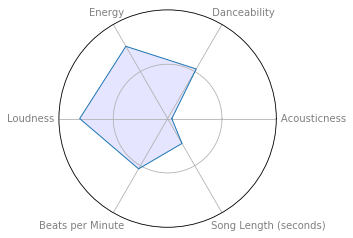

In [110]:
# number of variable
categories=list(original_album_means)[2:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=original_album_means.loc[0].drop(['album_number', 'Album Name']).values.flatten().tolist()
values += values[:1]
values
 

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=10)
 
# Draw ylabels
ax.set_rlabel_position(-22.5)
#plt.yticks([0,0.5,1.0], ["","  0.5"," 1.0"], color="grey", size=10)
plt.yticks([0,0.5,1.0], [""], color="grey", size=10)
plt.ylim(0,1.0)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

## Scrap Work Below

In [ ]:
#audio_df.head()
    
audio_df[audio_df.name == "Why'd You Only Call Me When You're High?"]


In [ ]:
rec_combined_df.head()

In [ ]:
test_df

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
test_track_search = sp.search(q = recommended_tracks[0], limit = 1, type = 'track')

In [ ]:
test_track_search